# Capstone 2024 - Table Recognition Work

Dataset:
[PubTables-1m](https://huggingface.co/datasets/bsmock/pubtables-1m)

Model: 
[YoloV11](https://docs.ultralytics.com/models/yolo11/)

In [1]:
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Val.tar.gz

--2024-10-16 07:42:40--  https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
Resolving huggingface.co (huggingface.co)... 18.160.143.99, 18.160.143.75, 18.160.143.76, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.99|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/36/c0/36c021133128a16f57db86f4cb105c85b76fb8fb4968b96642a02b5140872630/6b8c4b512e24e1040fa0829935ab9c2d13fc0015f7315cc8f13ef82a8bc95ca4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27PubTables-1M-Structure_Annotations_Val.tar.gz%3B+filename%3D%22PubTables-1M-Structure_Annotations_Val.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1729323760&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTMyMzc2MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNi9jMC8zNmMwMjExMzMxMjhhMTZmNTdkYjg2ZjRjYjEwNWM4NWI3NmZiOGZiNDk2OGI5NjY

In [2]:
!mkdir ./data
!mkdir ./data/PubTables-1M-Structure_Images_Val
!mkdir ./data/PubTables-1M-Structure_Annotations_Val
!tar -xf PubTables-1M-Structure_Images_Val.tar.gz -C ./data/PubTables-1M-Structure_Images_Val
!tar -xf PubTables-1M-Structure_Annotations_Val.tar.gz -C ./data/PubTables-1M-Structure_Annotations_Val

# Create YOLO Dataset

In [3]:
import os
import yaml
import shutil
import cv2
import random
import colorsys

import xml.etree.ElementTree as ET

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
classes = [
    'table column',
#     'table row',
#     'table spanning cell',
#     'table text cell'
]

def convert_coordinates(size, box):
    dw, dh = 1.0/size[0], 1.0/size[1]
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    x_center, y_center = xmin + w/2, ymin + h/2
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def convert_xml_to_yolo_and_copy_image(xml_file_path, dest_labels_dir, source_images_dir, dest_images_dir):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(source_images_dir, filename)
#     print(image_path)
    # Read image dimensions using PIL
    with Image.open(image_path) as img:
        width, height = img.size

    output_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(dest_labels_dir, output_filename), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                 float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
            bb = convert_coordinates((width, height), b)
            out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")
    
    # Copy corresponding image to train directory
    base_name = os.path.splitext(os.path.basename(xml_file_path))[0]
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_file = os.path.join(data_images_dir, base_name + ext)
        if os.path.exists(image_file):
#             print("Copied", image_file, dest_images_dir)
            shutil.copy(image_file, dest_images_dir)
            break
    return

In [5]:
def create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples=0, dataset_split_ratio = 0.8):

    xml_files = glob(os.path.join(data_labels_dir, '*.xml'))

    if number_of_samples:
        xml_files = xml_files[:number_of_samples]
    # Calculate the split index
    split_index = int(len(xml_files) * 0.8)  # Assuming 80% train, 20% val split

    # Split the files
    train_xml_files = xml_files[:split_index]
    val_xml_files = xml_files[split_index:]

    # Process train files
    for xml_file_path in train_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, train_labels_dir, data_images_dir, train_images_dir)

    # Process validation files
    for xml_file_path in val_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, val_labels_dir, data_images_dir, val_images_dir)

def create_dataset_yaml(dataset_dir, yaml_path):
  # Create the dataset structure
  dataset = {
      'path': os.path.abspath(dataset_dir),
      'train': 'train',  # Assuming all data is for training
      'val': 'val',    # Using same data for validation
    #   'test': 'train',   # Using same data for testing
      'names': {i: name for i, name in enumerate(classes)},
      'nc': len(classes)
  }

  # Write the YAML file
  with open(yaml_path, 'w') as file:
      yaml.dump(dataset, file, default_flow_style=False)

  print(f"Dataset YAML file created at: {yaml_path}")

In [6]:
data_dir = "/kaggle/working/data"
data_images_dir = "/kaggle/working/data/PubTables-1M-Structure_Images_Val"
data_labels_dir = "/kaggle/working/data/PubTables-1M-Structure_Annotations_Val"

dataset_dir = "/kaggle/working/dataset"
train_images_dir = os.path.join(dataset_dir, "train", "images")
train_labels_dir = os.path.join(dataset_dir, "train", "labels")
val_images_dir = os.path.join(dataset_dir, "val", "images")
val_labels_dir = os.path.join(dataset_dir, "val", "labels")

dataset_yaml_path = "/kaggle/working/dataset/dataset.yaml"

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

number_of_samples = 10000
dataset_split_ratio = 0.8

create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples,
    dataset_split_ratio
)
create_dataset_yaml(dataset_dir, dataset_yaml_path)

Dataset YAML file created at: /kaggle/working/dataset/dataset.yaml


In [7]:
# !rm -rf "/kaggle/working/dataset"

# Data sample visualization

37 37 196 278
196 37 249 278
249 37 307 278
307 37 353 278


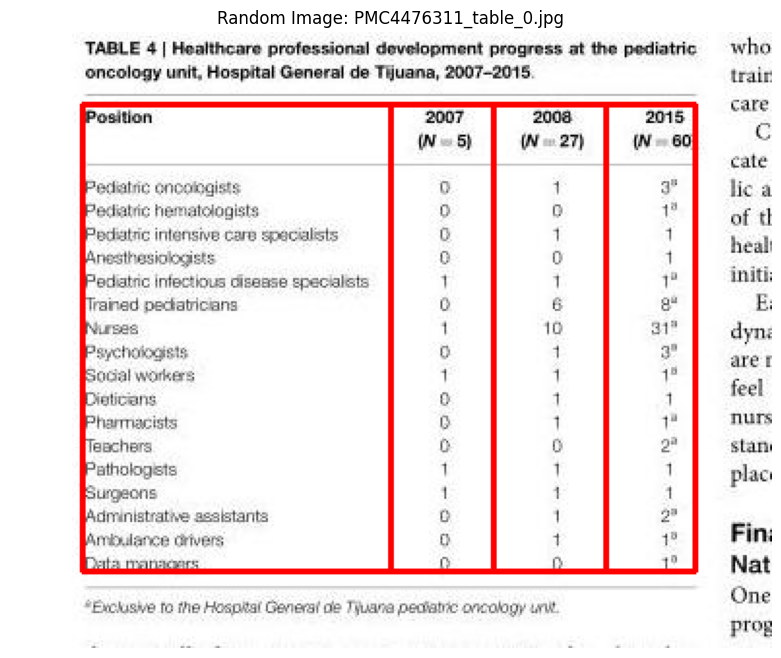

In [8]:
# Load the dataset configuration
with open(dataset_yaml_path, 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')
# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding label file
label_path = os.path.join(dataset_path, image_set, 'labels', random_image.rsplit('.', 1)[0] + '.txt')

# Read and parse the label file
with open(label_path, 'r') as file:
    labels = file.readlines()

# Get image dimensions
height, width, _ = image.shape

# Function to generate distinct colors
def generate_colors(n):
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    return list(map(lambda x: tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x)), hsv_tuples))

# Generate a color for each class
colors = generate_colors(len(class_names))

# Draw bounding boxes and labels
for label in labels:
    class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())

    # Convert YOLO format to pixel coordinates
    x1 = int((x_center - box_width/2) * width)
    y1 = int((y_center - box_height/2) * height)
    x2 = int((x_center + box_width/2) * width)
    y2 = int((y_center + box_height/2) * height)

    # Get color for this class
    color = colors[int(class_id)]

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    print(x1, y1, x2, y2)

    # Add label
    class_name = class_names[int(class_id)]
    # cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Random Image: {random_image}")
plt.show()

In [9]:
labels

['0 0.29841743002544535 0.4962957547169811 0.40420839694656496 0.7576594339622642\n',
 '0 0.5679529262086515 0.4962957547169811 0.13486259541984727 0.7576594339622642\n',
 '0 0.709139058524173 0.4962957547169811 0.147509669211196 0.7576594339622642\n',
 '0 0.8406361323155217 0.4962957547169811 0.11548447837150129 0.7576594339622642\n']

In [10]:
!rm -rf "/kaggle/working/data"
!rm -rf "/kaggle/working/*.tar"
!rm -rf "/kaggle/working/*.tar.gz"

# Model training

In [11]:
!pip install --no-cache-dir ultralytics
# !pip install -U ipywidgets
os.environ['WANDB_DISABLED'] = 'true'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 21.2 MB/s eta 0:00:00


In [12]:
from ultralytics import YOLO
model = YOLO("yolo11m.pt")
model.train(
    data=dataset_yaml_path,
    epochs=100,
    device="cuda",
    translate=0.2,
    scale=0.2,
    flipud=0.0
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 190MB/s]


Ultralytics 8.3.13 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 755k/755k [00:00<00:00, 11.0MB/s]
2024-10-16 07:44:28,333	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-16 07:44:30,425	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.18.3
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 65.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 8000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8000/8000 [00:07<00:00, 1037.46it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val/labels... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:02<00:00, 968.03it/s] 


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.73G      1.052     0.8372      1.244        167        640: 100%|██████████| 500/500 [04:34<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


                   all       2000      10760      0.981       0.98      0.992       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.59G     0.6537     0.4315     0.9855        166        640: 100%|██████████| 500/500 [04:31<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


                   all       2000      10760      0.765      0.541      0.603      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.67G     0.6973     0.4598      1.005        140        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.41it/s]

                   all       2000      10760      0.559      0.387      0.418      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.62G     0.6838     0.4607      1.005        187        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


                   all       2000      10760      0.317      0.268      0.179     0.0731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.55G     0.6373     0.4243      0.989        161        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.982      0.988      0.992      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.63G     0.5894     0.3931     0.9703        190        640: 100%|██████████| 500/500 [04:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.968      0.952      0.981      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.57G     0.5625     0.3765     0.9555        142        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


                   all       2000      10760      0.987      0.989      0.993      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.62G     0.5407     0.3556     0.9528        162        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.983      0.987      0.993      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.63G      0.523     0.3448      0.941        150        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760       0.97      0.948       0.98       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.59G     0.5045     0.3393     0.9326        194        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760       0.97      0.949      0.983      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.64G     0.4849     0.3238     0.9253        179        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.984      0.979      0.993      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.59G     0.4805     0.3198      0.926        249        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.992      0.993      0.994      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.62G     0.4705     0.3125     0.9224        169        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.993      0.993      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.63G     0.4578     0.3044     0.9148        161        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.991      0.993      0.994      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       8.6G     0.4536     0.3006     0.9144        161        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.995      0.993      0.994      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       8.6G     0.4445      0.296      0.911        165        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.36it/s]

                   all       2000      10760      0.806      0.644      0.747      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       8.6G      0.433     0.2902     0.9043        187        640: 100%|██████████| 500/500 [04:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.993      0.996      0.994      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.62G     0.4281      0.285     0.9039        161        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.992       0.99      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.52G     0.4235     0.2814     0.9029        200        640: 100%|██████████| 500/500 [04:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]

                   all       2000      10760      0.993      0.996      0.994      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.63G      0.417     0.2781     0.9013        167        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.991      0.995      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.59G     0.4081     0.2726     0.8943        195        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.994      0.994      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       8.6G     0.4053     0.2695     0.8954        196        640: 100%|██████████| 500/500 [04:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.992      0.995      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.63G     0.4066     0.2687     0.8966        169        640: 100%|██████████| 500/500 [04:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.993      0.997      0.994      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       8.6G     0.3968     0.2654     0.8941        185        640: 100%|██████████| 500/500 [04:28<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.32it/s]

                   all       2000      10760      0.993      0.994      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.63G     0.3921     0.2594     0.8921        179        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.996      0.996      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.64G     0.3892     0.2579      0.892        169        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.994      0.997      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       8.6G     0.3808     0.2534     0.8898        191        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.995      0.997      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.59G     0.3761     0.2517      0.886        188        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.993      0.996      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.62G     0.3801     0.2539     0.8872        163        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.995      0.997      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.59G     0.3717     0.2497     0.8856        186        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.995      0.997      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.62G     0.3665     0.2475     0.8841        162        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.32it/s]

                   all       2000      10760      0.996      0.997      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.62G     0.3615     0.2436     0.8825        158        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.996      0.997      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.64G     0.3592     0.2405     0.8792        146        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.995      0.995      0.994      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.62G     0.3571     0.2394     0.8826        171        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.995      0.997      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.63G     0.3509     0.2382     0.8808        161        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.995      0.998      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.59G     0.3482     0.2348     0.8788        198        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.996      0.997      0.994      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       8.6G     0.3428     0.2322     0.8777        190        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.996      0.997      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.62G     0.3423      0.229     0.8761        200        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]


                   all       2000      10760      0.996      0.998      0.994      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.59G     0.3412     0.2307      0.876        146        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.995      0.998      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.64G     0.3353     0.2266     0.8742        198        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.996      0.995      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       8.6G     0.3373     0.2271     0.8754        174        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.996      0.997      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.59G     0.3314     0.2251     0.8727        158        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.997      0.998      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.55G     0.3299     0.2245     0.8748        166        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.997      0.998      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.64G     0.3225       0.22     0.8734        176        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.996      0.998      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.55G     0.3238     0.2204     0.8752        193        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.995      0.999      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.63G     0.3211      0.219     0.8704        182        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.998      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.59G     0.3152     0.2129     0.8678        165        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.995      0.997      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.59G     0.3145     0.2139     0.8697        191        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.996      0.998      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.59G     0.3121      0.213     0.8687        132        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.994      0.998      0.994      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.59G     0.3067     0.2103     0.8646        198        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.997      0.998      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.56G     0.3058     0.2096     0.8649        164        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.995      0.998      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.59G     0.2973     0.2061     0.8605        177        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.998      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.59G     0.2984     0.2056     0.8645        215        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.999      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.62G     0.3009     0.2053     0.8635        159        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.997      0.998      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.64G     0.2932     0.2028     0.8612        144        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.998      0.998      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       8.6G     0.2923     0.2005     0.8598        166        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.998      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.55G     0.2922     0.1989     0.8646        178        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.993      0.997      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.59G     0.2911     0.1968     0.8618        170        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.997      0.998      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.61G     0.2915     0.1973      0.862        205        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.997      0.998      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.59G     0.2863     0.1959     0.8585        164        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.993      0.997      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.55G     0.2852      0.196     0.8594        201        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.996      0.998      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.64G     0.2844     0.1965     0.8572        173        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.995      0.998      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.55G      0.277     0.1918     0.8555        153        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.62G     0.2783     0.1936     0.8568        154        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.59G     0.2739     0.1894     0.8571        175        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.997      0.998      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.57G     0.2731     0.1895     0.8557        163        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.997      0.998      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.62G     0.2709     0.1859     0.8537        164        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       8.6G     0.2695     0.1863     0.8569        188        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.998      0.999      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.62G     0.2676     0.1832     0.8548        156        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


                   all       2000      10760      0.997      0.998      0.995      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.61G     0.2688     0.1847     0.8555        176        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.997      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.55G     0.2644      0.182     0.8524        164        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.997      0.998      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.62G     0.2653     0.1816     0.8529        215        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.997      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.64G      0.264     0.1829     0.8526        192        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.998      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.59G       0.26     0.1786     0.8502        152        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.996      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.63G     0.2565      0.178     0.8509        184        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.55G     0.2575     0.1792     0.8519        175        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      10760      0.997      0.999      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.56G      0.252     0.1737     0.8503        193        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.59G     0.2522     0.1744     0.8487        193        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.63G     0.2497     0.1718     0.8483        138        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.63G     0.2503     0.1729     0.8477        169        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.998      0.998      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.56G     0.2439     0.1705     0.8484        150        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.63G      0.242     0.1663     0.8478        175        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.54G     0.2415     0.1666     0.8468        162        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.998      0.998      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.56G     0.2431     0.1667     0.8472        159        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.55G     0.2396     0.1644     0.8461        223        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.59G     0.2379     0.1628     0.8468        203        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.59G     0.2373     0.1629     0.8464        182        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.997      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.64G     0.2367     0.1629     0.8471        183        640: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.63G     0.2314     0.1605     0.8443        165        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.59G     0.2316     0.1602     0.8445        181        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.997      0.999      0.995      0.992


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       8.6G     0.1587     0.1105     0.7866         98        640: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.64G      0.153     0.1071      0.786         74        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.62G     0.1512     0.1062     0.7855         87        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.32it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.6G     0.1481     0.1049     0.7842         90        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.59G     0.1441     0.1028     0.7831         83        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.33it/s]

                   all       2000      10760      0.998      0.999      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.55G     0.1431     0.1001     0.7797        111        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.998      0.999      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.63G     0.1391    0.09811     0.7811         77        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.36it/s]

                   all       2000      10760      0.998      0.999      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.62G     0.1392    0.09676     0.7816         90        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998      0.999      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.59G     0.1346    0.09523     0.7813         96        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]

                   all       2000      10760      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.55G     0.1359    0.09489     0.7816         76        640: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]

                   all       2000      10760      0.998          1      0.995      0.993



100 epochs completed in 8.022 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.13 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


                   all       2000      10760      0.998          1      0.995      0.993
Speed: 0.1ms preprocess, 5.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃████▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
wandb:                  lr/pg1 ▃████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁
wandb:                  lr/pg2 ▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
wandb:        metrics/mAP50(B) █▃▁█████████████████████████████████████
wandb:     metrics/mAP50-95(B) ▇▃▁▇▇▇▇█████████████████████████████████
wandb:    metrics/precision(B) █▄▁█████████████████████████████████████
wandb:       metrics/recall(B) ▁███████████████████████████████████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
wandb:          train/cls_loss █▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁
wandb:          train/dfl_loss █▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
wandb:            val/box_loss █▂▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7963347bef80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model testing


0: 416x640 5 table columns, 53.9ms
Speed: 2.0ms preprocess, 53.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


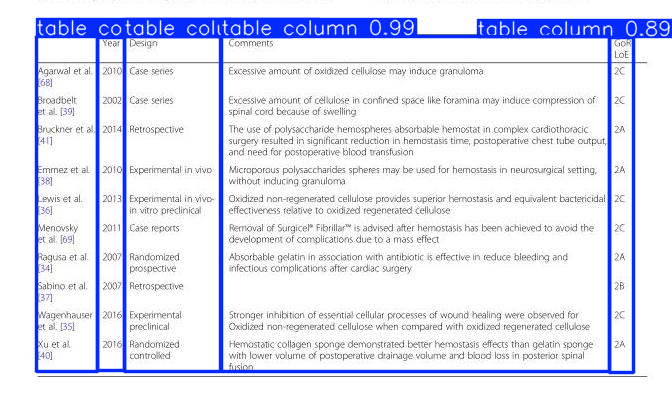

In [13]:
# Load the dataset configuration
with open(r"/kaggle/working/dataset/dataset.yaml", 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')

# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Run batched inference on a list of images
results = model([image_path])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

# Model export

In [14]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.13 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.6 MB)
requirements: Ultralytics requirements ['onnxslim==0.1.34', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 197.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 170.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 226.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 18.7s, installed 2 packages: ['onnxslim==0.1.34', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.34...
ONNX: export success ✅ 48.0s, saved as 'runs/detect/train/weights/best.onnx

'runs/detect/train/weights/best.onnx'